In [1]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pyhessian import hessian

from FLTrack.models import ShallowNN
import FLTrack.utils as utils

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [2]:
client_ids = [f"{i}_{j}" for i in range(4) for j in range(6)]

## Calculating eigen values 

This code snippet calculates and stores the top eigenvalues of Hessian matrices for models trained by all clients over the each global round. 

The results are organized into a dictionary, eigen_client_dict, with client IDs as keys.

In [3]:
eigen_client_dict = {}
for client in client_ids:
    client_data_loader = DataLoader(torch.load("trainpt/"+str(client)+".pt"), 64, shuffle = True)
    eigen_values = []
    for i in range (1,9):
        global_model = ShallowNN(features)
        checkpoint_path = os.path.join('checkpt', 'saving', 'epoch_500', f'global_{i}', 'global_model.pth')
        global_model.load_state_dict(torch.load(checkpoint_path))
        hessian_comp = hessian(global_model, loss_fn,  dataloader=client_data_loader, cuda=False)
        top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(maxIter=100)
        eigen_values.append(top_eigenvalues[0])
    eigen_client_dict[client] = eigen_values

/Users/tharuka/anaconda3/envs/fedce/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


FileNotFoundError: [Errno 2] No such file or directory: 'trainpt/0_5.pt'

In [60]:
#pd.DataFrame.from_dict(eigen_client_dict).to_csv("insights/eigen_values_over_global_iter.csv", index=False)

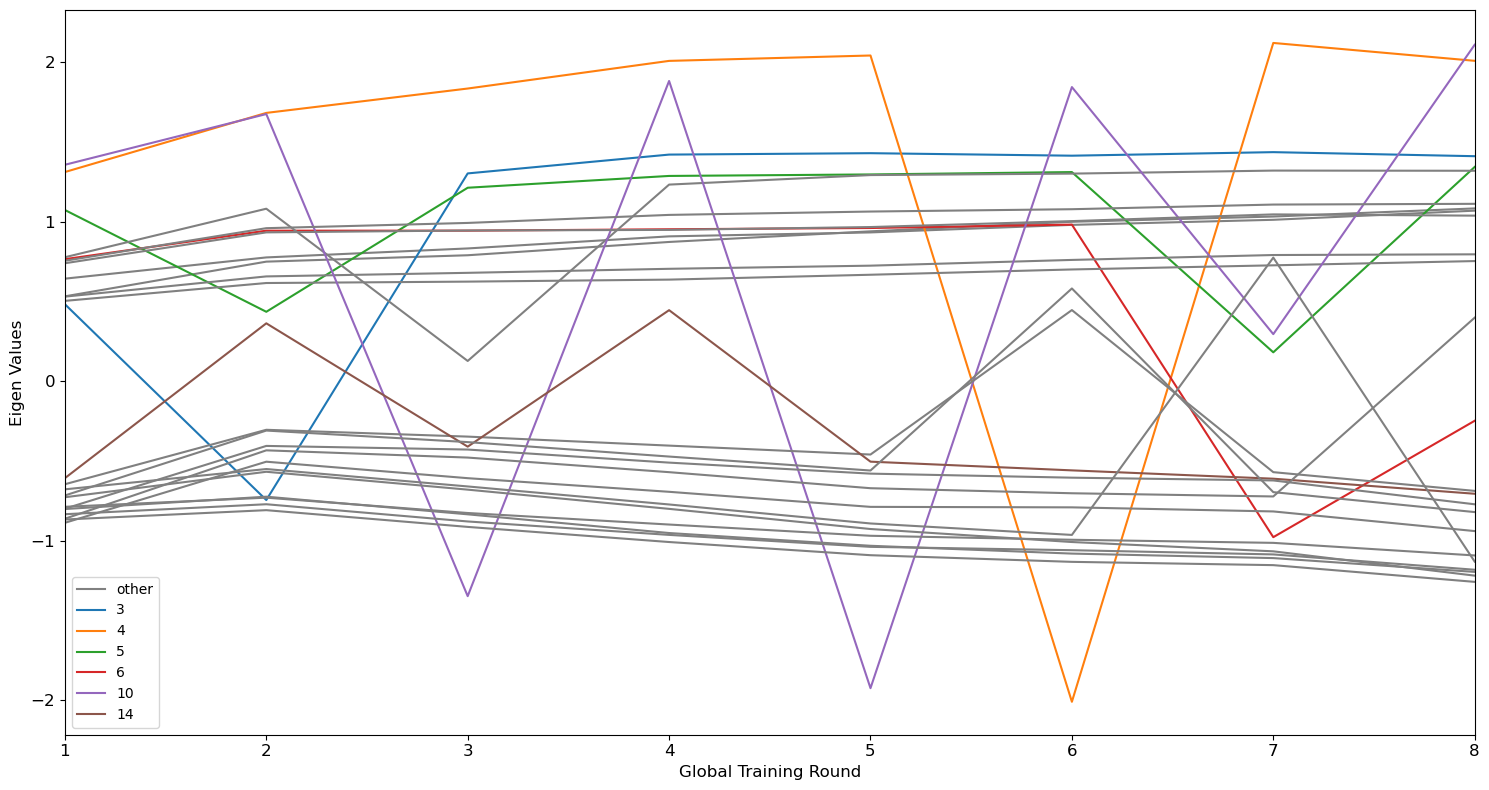

In [82]:
x_values = list(range(1, 9))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(eigen_client_dict.items()):
    if i+1 in [3,4,5,6,10,14]:
        plt.plot(x_values, values, label=str(i + 1))  # Set legend label from 1 to 24
    else:
        plt.plot(x_values, values, label="other",color='gray')
        
def legend_without_duplicate_labels(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    plt.legend(*zip(*unique))
    
plt.xlim(1,len(values))
#plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eigen Values', fontsize='large')
plt.legend(loc='upper right', ncol=4, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
legend_without_duplicate_labels(plt)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()

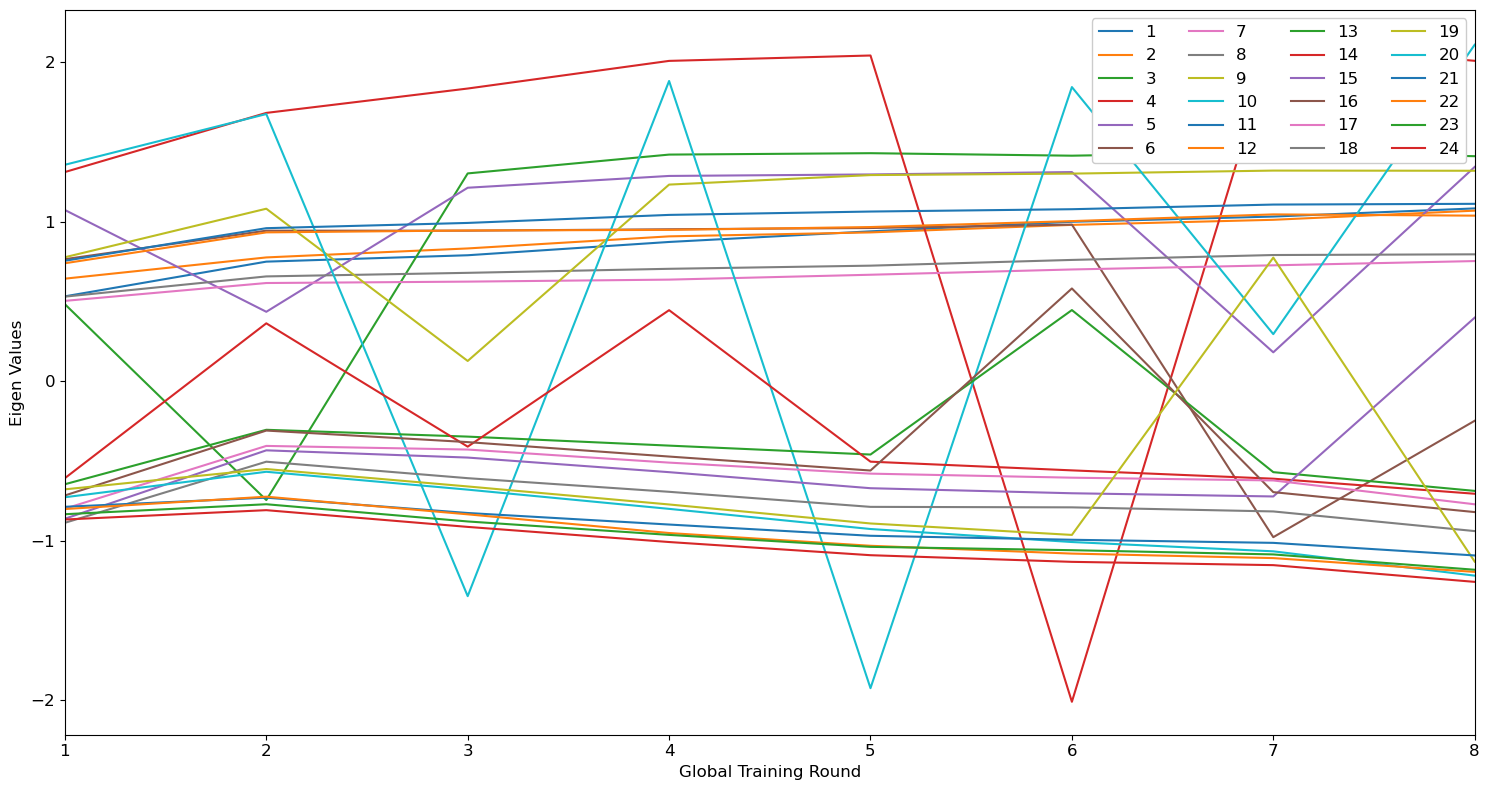

In [69]:
x_values = list(range(1, 9))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(eigen_client_dict.items()):
    plt.plot(x_values, values, label=str(i + 1))  # Set legend label from 1 to 24
    
plt.xlim(1,len(values))
#plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eigen Values', fontsize='large')
plt.legend(loc='upper right', ncol=4, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()

In [86]:
df = pd.read_csv("insights/eigen_values_over_global_iter.csv")

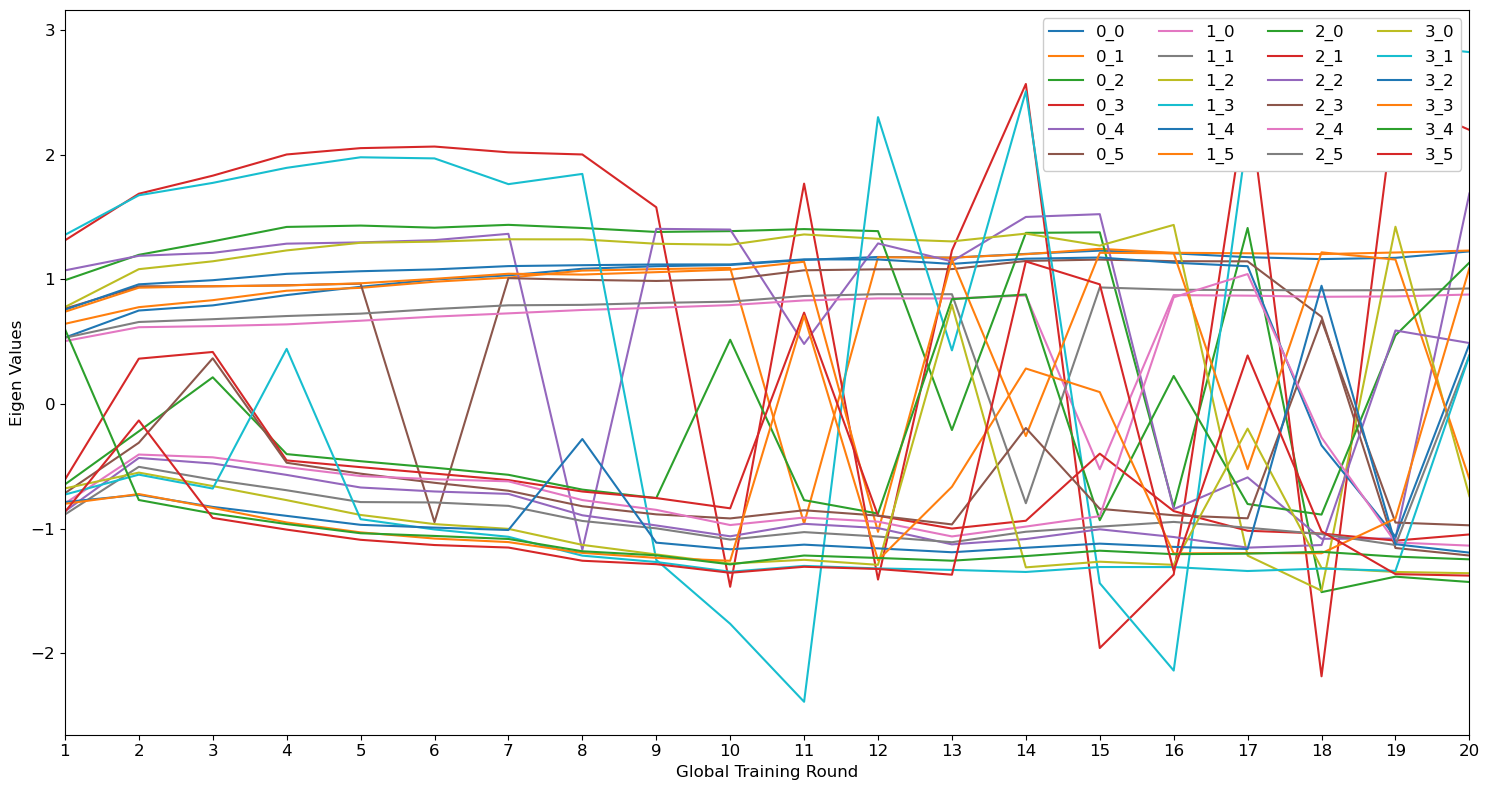

In [93]:
x_values = list(range(1, len(df) + 1))

plt.figure(figsize=(15, 8))

for i, column in enumerate(df.columns):
    if i+1 in [3,4,5,6,10,14]:
        plt.plot(x_values, df[column], label=column)
    else:
        plt.plot(x_values, df[column], label=column)

plt.xlim(1, len(x_values))
# You can uncomment the following line if you want to set a specific y-axis lower limit
# plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eigen Values', fontsize='large')
plt.legend(loc='upper right', ncol=4, bbox_to_anchor=(0, 0, 1, 1), fontsize='large', framealpha=1)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()